#### Import required packages

In [2]:
import time
import os
import shutil
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from PIL import Image
import csv
import operator 
import pandas as pd 
import seaborn as sns
import scipy.io as sio
import scipy.stats as stats
from cmath import nan, isnan
from numpy import isinf
import signal

In [3]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

#### Data loading and preprocessing

'load_data' function - load data in the form of list     
Each element represents list of 2 emelents - 1st one is INFO and 2nd one is data

In [5]:
def load_data(directory):
    data = []
    for filename in os.listdir(directory):
        # example: 'aw_mouse3_roi1_ses3_tr21.npy'
        f = os.path.join(directory, filename)
        
        list_of_subs = f.split("\\")[-1].split("_")
        list_of_subs[-1] = list_of_subs[-1][:-4]

        # get all numeric values from the filename
        for i in range(len(list_of_subs)):
            if list_of_subs[i][-2:].isdigit():
                list_of_subs[i] = int(list_of_subs[i][-2:])
            elif list_of_subs[i][-1].isdigit():
                list_of_subs[i] = int(list_of_subs[i][-1])
                
        # replace the string labels with integers
        if list_of_subs[0] == 'aw':
            list_of_subs[0] = 0
        elif list_of_subs[0] == 'an':
            list_of_subs[0] = 1

        all_info = {'label': list_of_subs[0], 'mouse': list_of_subs[1], 'roi': list_of_subs[2], 'ses': list_of_subs[3], 'tr': list_of_subs[4]}
        
        # load actual data
        dat = np.load(f)

        # append new data to the list
        data.append([all_info, dat])
    
    return data      

In [6]:
path = "C:/Users/Zephyrus/Marija/projekti/MINHEN/an_aw/data"
load_all_data = load_data(path)

In [7]:
print(len(load_all_data), len(load_all_data[0]))
print(load_all_data[0][0])

4800 2
{'label': 1, 'mouse': 1, 'roi': 1, 'ses': 1, 'tr': 1}


# Classification on anest and awake state

### Data preparation

Split data into train and test data for classification on AN and AW state

In [12]:
def train_test_split(mouse_id, data_vectors):
    train_data, train_labels, test_data, test_labels = [], [], [], []
    for data in data_vectors:
        if data[0]['mouse'] == mouse_id:
            test_data.append(data[1])
            test_labels.append(data[0]['label'])
        else:
            train_data.append(data[1])
            train_labels.append(data[0]['label'])

    # shuffle train data
    c = list(zip(train_data, train_labels))
    random.shuffle(c)
    train_data, train_labels = zip(*c)

    # shuffle test data
    c = list(zip(test_data, test_labels))
    random.shuffle(c)
    test_data, test_labels = zip(*c)
    
    return train_data, train_labels, test_data, test_labels

In [13]:
train_data, train_labels, test_data, test_labels = train_test_split(1, load_all_data)

In [14]:
print('Train len:',len(train_data), 'Test len:', len(test_data))
print('Shape of the initial data sample:', train_data[1000].shape)
print('Train labels 0/an:', len(train_labels)-np.sum(train_labels), 'Train labels 1/aw:', np.sum(train_labels))
print('Test labels 0/an:', len(test_labels)-np.sum(test_labels), 'Test labels 1/aw:', np.sum(test_labels))

Train len: 4000 Test len: 800
Shape of the initial data sample: (76, 5, 31)
Train labels 0/an: 2000 Train labels 1/aw: 2000
Test labels 0/an: 400 Test labels 1/aw: 400


'process_data' function - uses only stimuli after the 10th and gets data for the specific speaker       
adds '0's to fill the missing neurons and make all data same dimension

In [17]:
def process_data(sp, tr_data, ts_data):
    for i in range(len(tr_data)):
        tr_data[i] = tr_data[i][:,sp,10:].flatten()
    for i in range(len(ts_data)):
        ts_data[i] = ts_data[i][:,sp,10:].flatten()

    max_len_tr = max([len(i) for i in tr_data])
    max_len_ts = max([len(i) for i in ts_data])
    max_len = max(max_len_tr, max_len_ts)

    # fill with zeros float64
    for i in range(len(tr_data)):
        tr_data[i] = np.append(tr_data[i], np.zeros(max_len - len(tr_data[i])))
    for i in range(len(ts_data)):
        ts_data[i] = np.append(ts_data[i], np.zeros(max_len - len(ts_data[i])))

    tr_data = [list(i) for i in tr_data]
    ts_data = [list(i) for i in ts_data]

    return tr_data, ts_data

'extract_features' function     
- power spectral density (PSD) of the data - max, min, std, kurosis, skewness, entropy, average spike rate, burstiness and pattern 

In [18]:
def extract_features(tr_data, ts_data, tr_labels, ts_labels):
    power_tr, power_ts = [], []
    del_list = []
 
    for i in range(len(tr_data)):
        one_sample = []
        y = 0
        for sp in range(0,5):
            signal_neurons = tr_data[i][:,sp,:].flatten()
            if len(signal_neurons) == 0:
                del_list.append(i)
                y = 1
                continue

            # power spectrum
            signal_power = np.abs(np.fft.fft(signal_neurons))**2
            one_sample.append(np.max(signal_power))
            one_sample.append(np.min(signal_power))
            one_sample.append(np.std(signal_power))
            # kurtosis
            kurt = stats.kurtosis(signal_power)
            if isnan(kurt) or isinf(kurt): kurt = 0
            one_sample.append(kurt)
            # skewness
            skew = stats.skew(signal_power)
            if isnan(skew) or isinf(skew): skew = 0
            one_sample.append(skew)
            # entropy
            ent = stats.entropy(signal_power)
            if isnan(ent) or isinf(ent): ent = 0
            one_sample.append(ent)
            # average spike rate
            avg_spike_rate = np.mean(signal_power)
            if isnan(avg_spike_rate) or isinf(avg_spike_rate): avg_spike_rate = 0
            one_sample.append(avg_spike_rate)
            # burstiness
            burst = np.max(signal_power) / avg_spike_rate
            if isnan(burst) or isinf(burst): burst = 0
            one_sample.append(burst)
            # pattern
            pattern = np.max(signal_power) / np.mean(signal_power)
            if isnan(pattern) or isinf(pattern): pattern = 0
            one_sample.append(pattern)

        if y == 0:
            power_tr.append(one_sample)

    tr_labels = np.delete(tr_labels, del_list)
    del_list = []  

    for i in range(len(ts_data)):
        one_sample = []
        y = 0
        for sp in range(0,5):
            signal_neurons = ts_data[i][:,sp,:].flatten()
            if len(signal_neurons) == 0:
                del_list.append(i)
                y = 1
                continue

            # power spectrum
            signal_power = np.abs(np.fft.fft(signal_neurons))**2
            one_sample.append(np.max(signal_power))
            one_sample.append(np.min(signal_power))
            one_sample.append(np.std(signal_power))  
            # kurtosis
            kurt = stats.kurtosis(signal_power)
            if isnan(kurt) or isinf(kurt): kurt = 0
            one_sample.append(kurt)
            # skewness
            skew = stats.skew(signal_power)
            if isnan(skew) or isinf(skew): skew = 0
            one_sample.append(skew)
            # entropy
            ent = stats.entropy(signal_power)
            if isnan(ent) or isinf(ent): ent = 0
            one_sample.append(ent)
            # average spike rate
            avg_spike_rate = np.mean(signal_power)
            if isnan(avg_spike_rate) or isinf(avg_spike_rate): avg_spike_rate = 0
            one_sample.append(avg_spike_rate)
            # burstiness
            burst = np.max(signal_power) / avg_spike_rate
            if isnan(burst) or isinf(burst): burst = 0
            one_sample.append(burst)
            # pattern
            pattern = np.max(signal_power) / np.mean(signal_power)
            if isnan(pattern) or isinf(pattern): pattern = 0
            one_sample.append(pattern)
            
        if y == 0:
            power_ts.append(one_sample)

    ts_labels = np.delete(ts_labels, del_list)

    return power_tr, power_ts, tr_labels, ts_labels

In [77]:
train_data_proc, test_data_proc, train_labels_proc, test_labels_proc = extract_features(train_data, test_data, train_labels, test_labels)
#train_data_proc, test_data_proc = process_data(np.array(train_data), np.array(test_data))

In [59]:
print(len(train_data_proc), len(test_data_proc), len(train_labels_proc), len(test_labels_proc))
print(len(train_data_proc[0]), len(test_data_proc[0]))

3996 799 3996 799
45 45


### KNN

In [29]:
accs = []
conf_mats = []
for i in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_data_proc, train_labels_proc)
    knn_pred = knn.predict(test_data_proc)
    accs.append(accuracy_score(test_labels_proc, knn_pred))
    conf_mats.append(confusion_matrix(test_labels_proc, knn_pred))

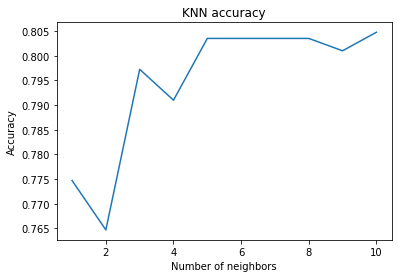

In [30]:
plt.plot(range(1, 11), accs)
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.title('KNN accuracy')
plt.show()

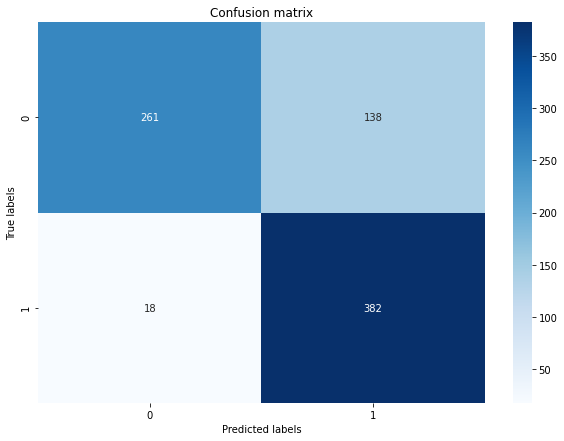

In [31]:
# confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mats[accs.index(max(accs))], annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

### RANDOM FOREST

#### One speaker, raw data - time point from 10th

In [320]:
accs, conf_mats = [], []

for mouse in range(1,7):
    tr_data, tr_labels, ts_data, ts_labels = train_test_split(mouse, load_all_data)
    accs_mouse, conf_mats_mouse = [], []

    for speaker in range(0, 5):
        tr_data_proc, ts_data_proc = process_data(speaker, tr_data, ts_data)
        rf = RandomForestClassifier(n_estimators=100)
        rf.fit(tr_data_proc, tr_labels)
        rf_pred = rf.predict(ts_data_proc)
    
        accs_mouse.append(accuracy_score(ts_labels, rf_pred))
        conf_mats_mouse.append(confusion_matrix(ts_labels, rf_pred))
    
    accs.append(accs_mouse)
    conf_mats.append(conf_mats_mouse)

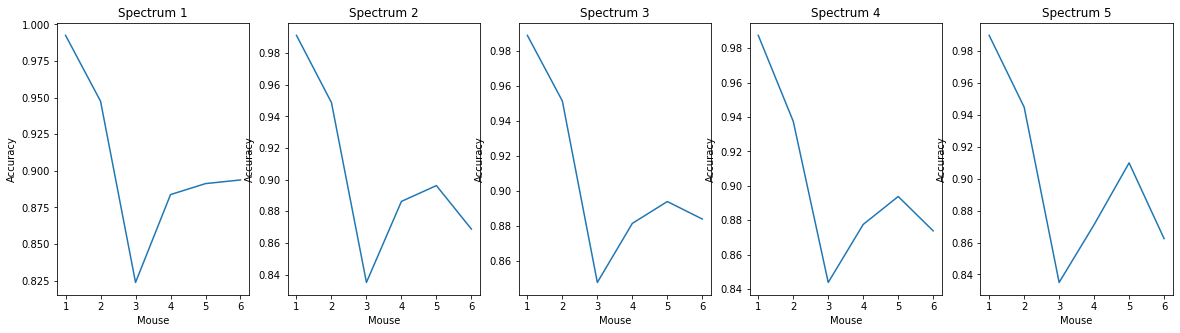

In [194]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    ax[i].plot(range(1, 7), [accs[j][i] for j in range(6)])
    ax[i].set_xlabel('Mouse')
    ax[i].set_ylabel('Accuracy')
    ax[i].set_title('Spectrum ' + str(i+1))
plt.show()

In [205]:
print('Average accuracies per speaker:')
for i in range(5):
    print('Speaker', i+1, ':', np.mean([accs[j][i] for j in range(6)]))
print('')

print('Avevrage accuracies per mouse:')
for i in range(6):
    print('Mouse', i+1, ':', np.mean(accs[i]))

accs

Average accuracies per speaker:
Speaker 1 : 0.9054166666666666
Speaker 2 : 0.904375
Speaker 3 : 0.9077083333333333
Speaker 4 : 0.9022916666666667
Speaker 5 : 0.9022916666666666

Avevrage accuracies per mouse:
Mouse 1 : 0.99
Mouse 2 : 0.9460000000000001
Mouse 3 : 0.8370000000000001
Mouse 4 : 0.8800000000000001
Mouse 5 : 0.897
Mouse 6 : 0.8765000000000001


[[0.9925, 0.99125, 0.98875, 0.9875, 0.99],
 [0.9475, 0.94875, 0.95125, 0.9375, 0.945],
 [0.82375, 0.835, 0.8475, 0.84375, 0.835],
 [0.88375, 0.88625, 0.88125, 0.8775, 0.87125],
 [0.89125, 0.89625, 0.89375, 0.89375, 0.91],
 [0.89375, 0.86875, 0.88375, 0.87375, 0.8625]]

#### All speakers, raw data - all time points

In [211]:
accs, conf_mats = [], []
accs_mouse, conf_mats_mouse = [], []
for mouse in range(1,7):
    tr_data, tr_labels, ts_data, ts_labels = train_test_split(mouse, load_all_data)
    tr_data_proc, ts_data_proc = process_data(sp, np.array(tr_data), np.array(ts_data))

    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(tr_data_proc, tr_labels)
    rf_pred = rf.predict(ts_data_proc)
    
    accs_mouse.append(accuracy_score(ts_labels, rf_pred))
    conf_mats_mouse.append(confusion_matrix(ts_labels, rf_pred))


In [214]:
accs_mouse

[0.99125, 0.96125, 0.8725, 0.8825, 0.90625, 0.8575]

#### All speakers, extracted fetures - all time points

In [19]:
accs_mouse, conf_mats_mouse = [], []

for mouse in range(1,7):
    tr_data, tr_labels, ts_data, ts_labels = train_test_split(mouse, load_all_data)
    tr_data_proc, ts_data_proc, tr_labels, ts_labels = extract_features(tr_data, ts_data, tr_labels, ts_labels)

    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(tr_data_proc, tr_labels)
    rf_pred = rf.predict(ts_data_proc)
    
    accs_mouse.append(accuracy_score(ts_labels, rf_pred))
    conf_mats_mouse.append(confusion_matrix(ts_labels, rf_pred))

In [20]:
accs_mouse

[0.9849812265331664,
 0.9924812030075187,
 0.7471839799749687,
 0.83125,
 0.9775,
 0.9011264080100125]

(-1.0, 10.0)

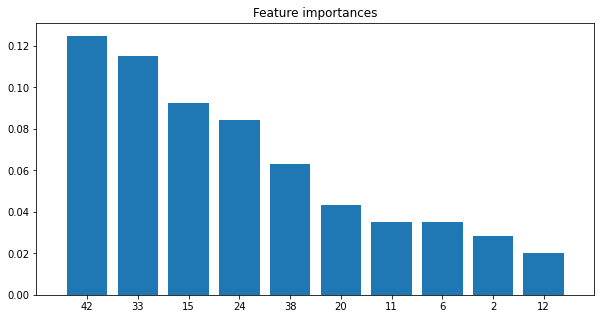

In [21]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

#select 10 most important features
indices = indices[:10]

#plot
plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(10), importances[indices], align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])

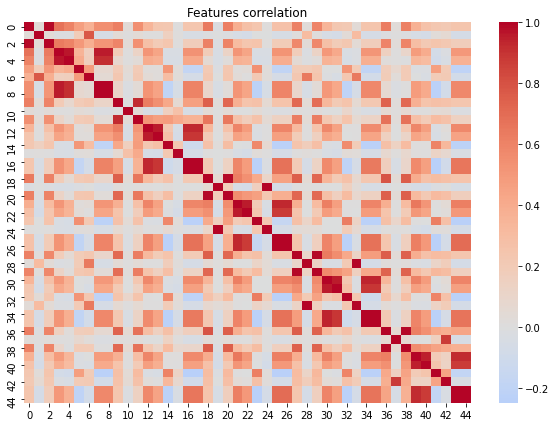

In [22]:
plt.figure(figsize=(10, 7))
sns.heatmap(np.corrcoef(tr_data_proc, rowvar=False), cmap='coolwarm', center=0)
plt.title('Features correlation')
plt.show()

# Classification on 5 different speakers

'train_test_split_speakers' function - split data into train and test data for classification on 5 different speakers    
one mouse is used for testing and the rest for training     
classification is performad on all 5 speakers and pairs of 2 speakers

In [7]:
def train_test_split_speakers(mouse_id, data_vectors):
    train_data, train_labels, test_data, test_labels = [], [], [], []
    for data in data_vectors:
        if data[0]['label'] == 0:
            if data[0]['mouse'] == mouse_id:
                all_sp_data = data[1]
                test_data.append(all_sp_data[:,1,:])
                test_labels.append(0)
                test_data.append(all_sp_data[:,4,:])
                test_labels.append(1)
            else:
                all_sp_data = data[1]
                train_data.append(all_sp_data[:,1,:])
                train_labels.append(0)
                train_data.append(all_sp_data[:,4,:])
                train_labels.append(1)

    # shuffle train data
    c = list(zip(train_data, train_labels))
    random.shuffle(c)
    train_data, train_labels = zip(*c)

    # shuffle test data
    c = list(zip(test_data, test_labels))
    random.shuffle(c)
    test_data, test_labels = zip(*c)

    return train_data, train_labels, test_data, test_labels

In [8]:
trd, trl, tsd, tsl = train_test_split_speakers(1, load_all_data)

In [9]:
print('Train len:',len(trd), 'Test len:', len(tsd))
print(set(trl), set(tsl))

Train len: 4000 Test len: 800
{0, 1} {0, 1}


'extract_features' function - power spectral density (PSD) of the data - max, min, std, kurosis, skewness, entropy, average spike rate, burstiness and pattern

In [112]:
def extract_features(tr_data, ts_data, tr_labels, ts_labels):
    power_tr_all, power_ts_all = [], []
    del_list = []
 
    for i in range(len(tr_data)):
        power_tr = []
        y = 0
        
        signal_neurons = tr_data[i].flatten()
        if len(signal_neurons) == 0:
            del_list.append(i)
            y = 1
            continue

        # power spectrum
        signal_power = np.abs(np.fft.fft(signal_neurons))**2
        power_tr.append(np.max(signal_power))
        power_tr.append(np.min(signal_power))
        power_tr.append(np.std(signal_power))
        # kurtosis
        kurt = stats.kurtosis(signal_power)
        if isnan(kurt) or isinf(kurt): kurt = 0
        power_tr.append(kurt)
        # skewness
        skew = stats.skew(signal_power)
        if isnan(skew) or isinf(skew): skew = 0
        power_tr.append(skew)
        # entropy
        ent = stats.entropy(signal_power)
        if isnan(ent) or isinf(ent): ent = 0
        power_tr.append(ent)
        # average spike rate
        avg_spike_rate = np.mean(signal_power)
        if isnan(avg_spike_rate) or isinf(avg_spike_rate): avg_spike_rate = 0
        power_tr.append(avg_spike_rate)
        # burstiness
        burst = np.max(signal_power) / avg_spike_rate
        if isnan(burst) or isinf(burst): burst = 0
        power_tr.append(burst)
        # pattern
        pattern = np.max(signal_power) / np.mean(signal_power)
        if isnan(pattern) or isinf(pattern): pattern = 0
        power_tr.append(pattern)

        if y == 0:
            power_tr_all.append(power_tr)

    tr_labels = np.delete(tr_labels, del_list)
    del_list = []  

    for i in range(len(ts_data)):
        power_ts = []
        y = 0
        signal_neurons = ts_data[i].flatten()
        if len(signal_neurons) == 0:
            del_list.append(i)
            y = 1
            continue

        # power spectrum
        signal_power = np.abs(np.fft.fft(signal_neurons))**2
        power_ts.append(np.max(signal_power))
        power_ts.append(np.min(signal_power))
        power_ts.append(np.std(signal_power))  
        # kurtosis
        kurt = stats.kurtosis(signal_power)
        if isnan(kurt) or isinf(kurt): kurt = 0
        power_ts.append(kurt)
        # skewness
        skew = stats.skew(signal_power)
        if isnan(skew) or isinf(skew): skew = 0
        power_ts.append(skew)
        # entropy
        ent = stats.entropy(signal_power)
        if isnan(ent) or isinf(ent): ent = 0
        power_ts.append(ent)
        # average spike rate
        avg_spike_rate = np.mean(signal_power)
        if isnan(avg_spike_rate) or isinf(avg_spike_rate): avg_spike_rate = 0
        power_ts.append(avg_spike_rate)
        # burstiness
        burst = np.max(signal_power) / avg_spike_rate
        if isnan(burst) or isinf(burst): burst = 0
        power_ts.append(burst)
        # pattern
        pattern = np.max(signal_power) / np.mean(signal_power)
        if isnan(pattern) or isinf(pattern): pattern = 0
        power_ts.append(pattern)

        if y == 0:
            power_ts_all.append(power_ts)

    ts_labels = np.delete(ts_labels, del_list)

    return power_tr_all, power_ts_all, tr_labels, ts_labels

'extract_features_corr' function - calculates correlation between all neurons and finds:    
- max correlation, min correlation, std of correlation, average correlation for each neuron     
- it can return those lists concatedated or calculate statistical features from them (max, min, std, mean)

In [151]:
def extract_features_corr(tr_data, ts_data, tr_labels, ts_labels):
    power_tr_all, power_ts_all = [], []
    del_list = []
 
    for i in range(len(tr_data)):
        power_tr = []
        
        # correlation between neurons in tr_data[i]
        corr = np.corrcoef(tr_data[i])
        # exclude all raw with all nans and columns with all nans from corr
        corr = corr[~np.all(np.isnan(corr), axis=1)]
        corr = corr[:, ~np.all(np.isnan(corr), axis=0)]

        if len(corr.flatten()) == 0:
            del_list.append(i)
            continue

        maxs, mins, stds, means = [], [], [], []
        for neuron in corr:
            maxs.append(np.max(neuron))
            mins.append(np.min(neuron))
            stds.append(np.std(neuron))
            means.append(np.mean(neuron))
        '''
        power_tr.append(np.max(maxs))
        power_tr.append(np.min(maxs))
        power_tr.append(np.std(maxs))
        power_tr.append(np.mean(maxs))
        power_tr.append(np.max(mins))
        power_tr.append(np.min(mins))
        power_tr.append(np.std(mins))
        power_tr.append(np.mean(mins))
        power_tr.append(np.max(stds))
        power_tr.append(np.min(stds))
        power_tr.append(np.std(stds))
        power_tr.append(np.mean(stds))
        power_tr.append(np.max(means))
        power_tr.append(np.min(means))
        power_tr.append(np.std(means))
        power_tr.append(np.mean(means))
        '''
        #concat maxs, mins, stds, means
        power_tr = maxs + mins + stds + means

        power_tr_all.append(power_tr)

    tr_labels = np.delete(tr_labels, del_list)
    del_list = []  

    for i in range(len(ts_data)):
        power_ts = []

        # correlation between neurons in ts_data[i]
        corr = np.corrcoef(ts_data[i], rowvar=False)
        # exclude all raw with all nans and columns with all nans from corr
        corr = corr[~np.all(np.isnan(corr), axis=1)]
        corr = corr[:, ~np.all(np.isnan(corr), axis=0)]
        
        if len(corr.flatten()) == 0:
            del_list.append(i)
            continue
        
        maxs, mins, stds, means = [], [], [], []
        for neuron in corr:
            maxs.append(np.max(neuron)) 
            mins.append(np.min(neuron))
            stds.append(np.std(neuron))
            means.append(np.mean(neuron))

        '''
        power_ts.append(np.max(maxs))
        power_ts.append(np.min(maxs))
        power_ts.append(np.std(maxs))
        power_ts.append(np.mean(maxs))
        power_ts.append(np.max(mins))
        power_ts.append(np.min(mins))
        power_ts.append(np.std(mins))
        power_ts.append(np.mean(mins))
        power_ts.append(np.max(stds))
        power_ts.append(np.min(stds))
        power_ts.append(np.std(stds))
        power_ts.append(np.mean(stds))
        power_ts.append(np.max(means))
        power_ts.append(np.min(means))
        power_ts.append(np.std(means))
        power_ts.append(np.mean(means))
        '''

        #concat maxs, mins, stds, means
        power_ts = maxs + mins + stds + means
        
        power_ts_all.append(power_ts)

    ts_labels = np.delete(ts_labels, del_list)

    max_len_tr = max([len(i) for i in power_tr_all])
    max_len_ts = max([len(i) for i in power_ts_all])
    max_len = max(max_len_tr, max_len_ts)

    # fill with zeros float64
    for i in range(len(power_tr_all)):
        power_tr_all[i] = np.append(power_tr_all[i], np.zeros(max_len - len(power_tr_all[i]))) 
    for i in range(len(power_ts_all)):
        power_ts_all[i] = np.append(power_ts_all[i], np.zeros(max_len - len(power_ts_all[i])))

    power_tr_all = [list(i) for i in power_tr_all]
    power_ts_all = [list(i) for i in power_ts_all]

    return power_tr_all, power_ts_all, tr_labels, ts_labels

'process_data' function - uses only stimuli after the 10th one and fills empty information with '0's

In [10]:
def process_data(tr_data, ts_data):

    tr_data = [np.array(i) for i in tr_data]
    ts_data = [np.array(i) for i in ts_data]
    tr_data = np.array(tr_data)
    ts_data = np.array(ts_data)
    
    for i in range(len(tr_data)):
        tr_data[i] = tr_data[i][:,:].flatten()
    for i in range(len(ts_data)):
        ts_data[i] = ts_data[i][:,:].flatten()

    max_len_tr = max([len(i) for i in tr_data])
    max_len_ts = max([len(i) for i in ts_data])
    max_len = max(max_len_tr, max_len_ts)

    # fill with zeros float64
    for i in range(len(tr_data)):
        tr_data[i] = np.append(tr_data[i], np.zeros(max_len - len(tr_data[i])))
    for i in range(len(ts_data)):
        ts_data[i] = np.append(ts_data[i], np.zeros(max_len - len(ts_data[i])))

    tr_data = [list(i) for i in tr_data]
    ts_data = [list(i) for i in ts_data]

    return tr_data, ts_data

In [18]:
trd, trl, tsd, tsl = train_test_split_speakers(1, load_all_data)
#train_data_proc, test_data_proc, trl, tsl = extract_features_corr(trd, tsd, trl, tsl)
train_data_proc, test_data_proc = process_data(trd, tsd)

In [19]:
print(len(train_data_proc), len(test_data_proc), len(trl), len(tsl))

4000 800 4000 800


In [20]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_data_proc, trl)
rf_pred = rf.predict(test_data_proc)
accuracy_score(tsl, rf_pred)

0.54125

In [21]:
xgb = XGBClassifier()
xgb.fit(train_data_proc, trl)
xgb_pred = xgb.predict(test_data_proc)
accuracy_score(tsl, xgb_pred)

[22:50:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.55875

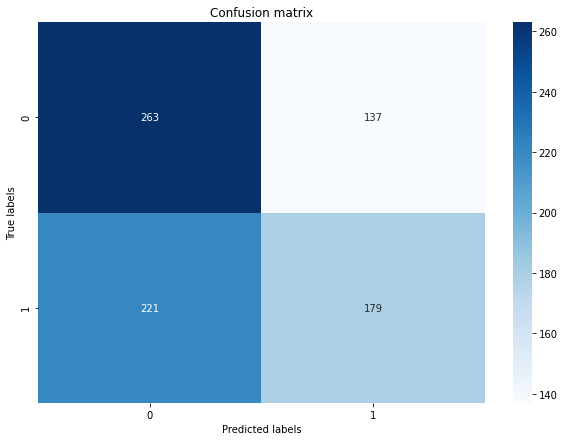

In [15]:
conf_mats = []
conf_mats.append(confusion_matrix(tsl, rf_pred))
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mats[0], annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

# RespPeak classification

In [8]:
path = "C:/Users/Zephyrus/Marija/projekti/MINHEN/an_aw/data_resppeak"
load_all_data = load_data(path)

In [112]:
print(len(load_all_data), len(load_all_data[0]))
print(load_all_data[0][0])
print(np.array(load_all_data[0][1]).shape)

4800 2
{'label': 1, 'mouse': 1, 'roi': 1, 'ses': 1, 'tr': 1}
(92, 5)


In [113]:
def train_test_speakers_resppeak(mouse_id, data_vectors):
    train_data, train_labels, test_data, test_labels = [], [], [], []
    for data in data_vectors:
        # if data is awake state
        if data[0]['label'] == 0:
            # which mouse's gonna be in the test set
            if data[0]['mouse'] == mouse_id:
                all_sp_data = data[1]
                test_data.append(all_sp_data[:,1])
                test_labels.append(0)
                test_data.append(all_sp_data[:,4])
                test_labels.append(1)
            else:
                all_sp_data = data[1]
                train_data.append(all_sp_data[:,1])
                train_labels.append(0)
                train_data.append(all_sp_data[:,4])
                train_labels.append(1)

    # shuffle train data
    c = list(zip(train_data, train_labels))
    random.shuffle(c)
    train_data, train_labels = zip(*c)

    # shuffle test data
    c = list(zip(test_data, test_labels))
    random.shuffle(c)
    test_data, test_labels = zip(*c)

    return train_data, train_labels, test_data, test_labels

In [114]:
def process_data(tr_data, ts_data, tr_label, ts_label):
    tr_data_ = [np.array(i) for i in tr_data]
    ts_data_ = [np.array(i) for i in ts_data]
    tr_data_ = np.array(tr_data_)
    ts_data_ = np.array(ts_data_)    

    for i in range(len(tr_data_)):
        tr_data_[i] = tr_data_[i][:].flatten()
    for i in range(len(ts_data)):
        ts_data_[i] = ts_data_[i][:].flatten()

    tr_data, ts_data = [], []
    tr_l, ts_l = [], []
    for j in range(len(tr_data_)):
        if len(tr_data_[j]) == 0:
            continue
        tr_data.append(tr_data_[j])
        tr_l.append(tr_label[j])
    for j in range(len(ts_data_)):
        if len(ts_data_[j]) == 0:
            continue
        ts_data.append(ts_data_[j])
        ts_l.append(ts_label[j])
    
    # normalize data
    for j in range(len(tr_data)):
        if np.max(tr_data[j]) - np.min(tr_data[j]) == 0:
            continue
        tr_data[j] = (tr_data[j] - np.min(tr_data[j])) / (np.max(tr_data[j]) - np.min(tr_data[j]))

    for j in range(len(ts_data)):
        if np.max(ts_data[j]) - np.min(ts_data[j]) == 0:
            continue
        ts_data[j] = (ts_data[j] - np.min(ts_data[j])) / (np.max(ts_data[j]) - np.min(ts_data[j]))

    max_len_tr = max([len(i) for i in tr_data])
    max_len_ts = max([len(i) for i in ts_data])
    max_len = max(max_len_tr, max_len_ts)

    # fill with zeros float64
    for i in range(len(tr_data)):
        tr_data[i] = np.append(tr_data[i], np.zeros(max_len - len(tr_data[i])))
    for i in range(len(ts_data)):
        ts_data[i] = np.append(ts_data[i], np.zeros(max_len - len(ts_data[i])))

    tr_data = [list(i) for i in tr_data]
    ts_data = [list(i) for i in ts_data]

    return tr_data, ts_data, tr_l, ts_l

In [300]:
def extract_features(tr_data, ts_data, tr_label, ts_label):

    tr_data_ = [np.array(i) for i in tr_data]
    ts_data_ = [np.array(i) for i in ts_data]
    tr_data_ = np.array(tr_data_)
    ts_data_ = np.array(ts_data_)    

    for i in range(len(tr_data_)):
        tr_data_[i] = tr_data_[i][:].flatten()
    for i in range(len(ts_data)):
        ts_data_[i] = ts_data_[i][:].flatten()

    tr_data, ts_data = [], []
    tr_l, ts_l = [], []
    for j in range(len(tr_data_)):
        if len(tr_data_[j]) == 0:
            continue
        tr_data.append(tr_data_[j])
        tr_l.append(tr_label[j])
    for j in range(len(ts_data_)):
        if len(ts_data_[j]) == 0:
            continue
        ts_data.append(ts_data_[j])
        ts_l.append(ts_label[j])
    
    # normalize data
    for j in range(len(tr_data)):
        if np.max(tr_data[j]) - np.min(tr_data[j]) == 0:
            continue
        tr_data[j] = (tr_data[j] - np.min(tr_data[j])) / (np.max(tr_data[j]) - np.min(tr_data[j]))

    for j in range(len(ts_data)):
        if np.max(ts_data[j]) - np.min(ts_data[j]) == 0:
            continue
        ts_data[j] = (ts_data[j] - np.min(ts_data[j])) / (np.max(ts_data[j]) - np.min(ts_data[j]))

    corr_tr = []
    for i in range(len(tr_data)):
        corr = np.correlate(tr_data[i], tr_data[i], mode='full')
        iqr1 = np.percentile(tr_data[i], 75) - np.percentile(tr_data[i], 25)
        iqr2 = np.percentile(corr, 75) - np.percentile(corr, 25)
        corr_tr.append([np.max(tr_data[i]), np.min(tr_data[i]), np.std(tr_data[i]), np.mean(tr_data[i]),\
             np.var(tr_data[i]), abs(np.max(tr_data[i])-np.min(tr_data[i])), iqr1, np.max(corr), np.min(corr),\
                 np.std(corr), np.mean(corr), np.var(corr), abs(np.max(corr)-np.min(corr)), iqr2])
        corr_tr[-1] = [corr_tr[-1][11], corr_tr[-1][7], corr_tr[-1][12], corr_tr[-1][13], corr_tr[-1][10], corr_tr[-1][9], corr_tr[-1][5], corr_tr[-1][0]]

        
    corr_ts = []
    for i in range(len(ts_data)):
        corr = np.correlate(ts_data[i], ts_data[i], mode='full')
        iqr1 = np.percentile(ts_data[i], 75) - np.percentile(ts_data[i], 25)
        iqr2 = np.percentile(corr, 75) - np.percentile(corr, 25)
        corr_ts.append([np.max(ts_data[i]), np.min(ts_data[i]), np.std(ts_data[i]), np.mean(ts_data[i]),\
             np.var(ts_data[i]), abs(np.max(ts_data[i])-np.min(ts_data[i])), iqr1, np.max(corr), np.min(corr),\
                 np.std(corr), np.mean(corr), np.var(corr), abs(np.max(corr)-np.min(corr)), iqr2])
        corr_ts[-1] = [corr_ts[-1][11], corr_ts[-1][7], corr_ts[-1][12], corr_ts[-1][13], corr_ts[-1][10], corr_ts[-1][9], corr_ts[-1][5], corr_ts[-1][0]]
        
    '''
    pca = PCA(n_components=2)
    pca.fit(corr_tr)
    corr_tr = pca.transform(corr_tr)
    corr_ts = pca.transform(corr_ts)
    '''
    
    tr_data = [list(i) for i in corr_tr]
    ts_data = [list(i) for i in corr_ts]

    return tr_data, ts_data, tr_l, ts_l

In [301]:
tr, trl, ts, tsl = train_test_speakers_resppeak(1, load_all_data)
train_data_proc, test_data_proc, train_label_proc, test_label_proc = process_data(tr, ts, trl, tsl)
#train_data_proc, test_data_proc, train_label_proc, test_label_proc = extract_features(tr, ts, trl, tsl)
print(len(train_data_proc), len(test_data_proc), len(train_label_proc), len(test_label_proc))

3994 798 3994 798


In [307]:
accuracies = []
for k in range(1):
    tr, trl, ts, tsl = train_test_speakers_resppeak(1, load_all_data)
    train_data_proc, test_data_proc, train_label_proc, test_label_proc = extract_features(tr, ts, trl, tsl)
    
    gnb = GaussianNB()
    gnb.fit(train_data_proc, train_label_proc)
    gnb_pred = gnb.predict(test_data_proc)
    accuracies.append(accuracy_score(test_label_proc, gnb_pred))

In [308]:
print(accuracies)
print(np.round(np.mean(accuracies), 3), np.round(np.std(accuracies), 3))

[0.7117794486215538]
0.712 0.0


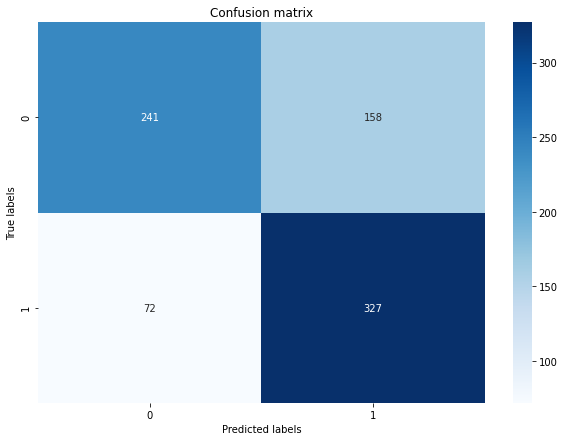

In [309]:
conf_mats = []
conf_mats.append(confusion_matrix(test_label_proc, gnb_pred))
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mats[0], annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

In [310]:
#feature importance
importances = gnb.theta_
indices = np.argsort(importances)[0][::-1]

importances, indices

(array([[19.19934831, 13.09762508, 12.97474847,  5.71714028,  5.63377712,
          3.30336096,  0.9098648 ,  0.9098648 ],
        [21.12290561, 14.19278771, 14.05998018,  6.25229003,  6.14180673,
          3.60323162,  0.9354031 ,  0.9354031 ]]),
 array([0, 1, 2, 3, 4, 5, 7, 6], dtype=int64))

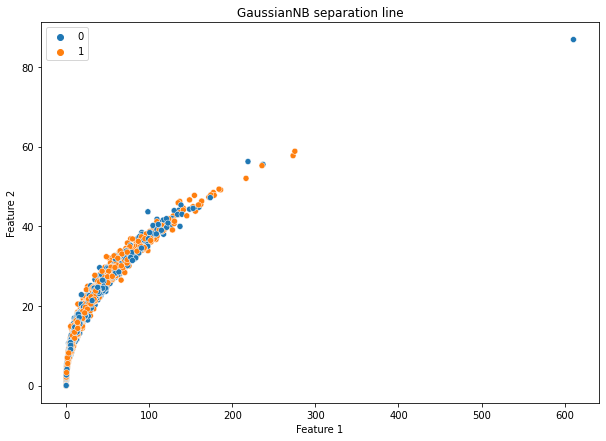

In [311]:
# gnb separation line
plt.figure(figsize=(10, 7))
sns.scatterplot(x=np.array(train_data_proc)[:,0], y=np.array(train_data_proc)[:,1], hue=train_label_proc)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('GaussianNB separation line')
plt.show()